In [15]:
from library.ccba import *
import sys
sys.path.insert(0, '/Users/Kwat/binf/code/')
from kz_code import *
#from scipy.spatial import distance
%matplotlib inline

In [6]:
# Read gene expression
gene_x_sample_df = pd.read_csv('./data/GES24759/GSE24759_series_matrix.txt', sep='\t', comment='!', index_col=0)
print('gene_x_sample_df shape: {}'.format(gene_x_sample_df.shape))

gene_x_sample_df shape: (22944, 211)


In [7]:
# NMF and select k
nmf_results, scores = score_k(gene_x_sample_df, [2,3,4,5,6,7,8,9,10,11,12,13,14,15], verbose=True)

Computing clustering score for k=2 ...
Computing clustering score for k=3 ...
Computing clustering score for k=4 ...
Computing clustering score for k=5 ...
Computing clustering score for k=6 ...
Computing clustering score for k=7 ...
Computing clustering score for k=8 ...


/Applications/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Computing clustering score for k=9 ...
Computing clustering score for k=10 ...
Computing clustering score for k=11 ...
Computing clustering score for k=12 ...
Computing clustering score for k=13 ...
Computing clustering score for k=14 ...
Computing clustering score for k=15 ...


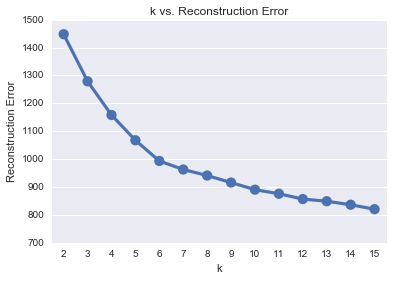

In [8]:
# Plot reconstruction error
ax = sns.pointplot(x=list(nmf_results.keys()), y=[v['err'] for v in nmf_results.values()])
ax.set(xlabel='k', ylabel='Reconstruction Error')
ax.set_title('k vs. Reconstruction Error')
plt.show()

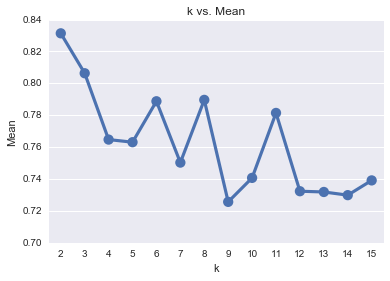

In [9]:
ax = sns.pointplot(x=[k for k, v in scores.items()], y=[v['mean'] for k, v in scores.items()])
ax.set(xlabel='k', ylabel='Mean')
ax.set_title('k vs. Mean')
plt.show()

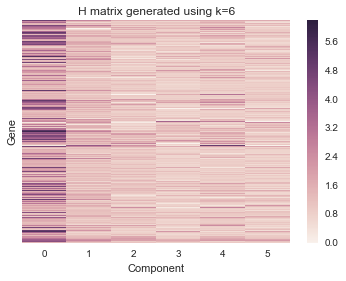

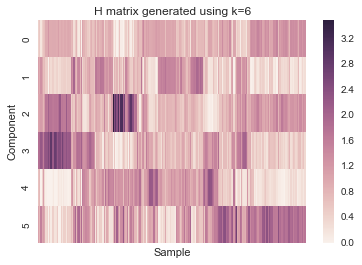

In [11]:
# Plot W and H matrices
k = 6
ax = sns.heatmap(nmf_results[k]['W'], yticklabels=False)
ax.set(xlabel='Component', ylabel='Gene')
ax.set_title('H matrix generated using k={}'.format(k))
plt.show()

ax = sns.heatmap(nmf_results[k]['H'], xticklabels=False)
ax.set(xlabel='Sample', ylabel='Component')
ax.set_title('H matrix generated using k={}'.format(k))
plt.show()

In [12]:
# Make gene-to-info dictionary
with open('./data/GES24759/GSE24759_family.soft') as f:
    gene_info = {}
    parse_errors = {}
    gene_symbol_errors = {}
    parse = False
    for i, line in enumerate(f.readlines()):
        line = line.strip()
        if not parse:
            if line == '!platform_table_begin':
                parse = True
                print('Start parsing at line {}'.format(i))
        else:
            if line == '!platform_table_end':
                print('Stop parsing at line {}'.format(i))
                parse = False
                break
            else:
                split = line.split('\t')
                try:
                    if (split[8] == '' or split[8] =='NA'):
                        gene_symbol_errors[split[0]] = line
                        continue
                    elif split[0] in gene_info:
                        print('Duplicate at {}'.format(split[0]))
                    else:
                        gene_info[split[0]] = {'gene_title':split[7],
                                               'gene_symbol':split[8].split(' /// '),
                                               'entrez_gene':split[9],
                                               'refseq':split[10].split(' /// ')}
                except:
                    parse_errors[split[0]] = line
    print('Parse error: {}'.format(len(parse_errors)))
    print('Gene symbol error {}'.format(len(gene_symbol_errors)))

Start parsing at line 277
Stop parsing at line 23223
Parse error: 1173
Gene symbol error 741


In [16]:
# TODO: figure out why the number of passing values are the same for eother_ch col in W
top_genes = {}  # dictionary(key:component; value:top genes)

percentile = 0.99
for i in range(nmf_results[k]['W'].shape[1]):
    name = 'k{}c{}'.format(k, i)
    print('Analyzing {} ...'.format(name))
    
    top_genes[name] = set()
    
    col = nmf_results[k]['W'][:, i]
    threshold = quantile(col, 100/((1-percentile)*100))[-1]
    indices_passing_threshold = np.nonzero(np.greater_equal(col, threshold)*col)[0]
    print('{} genes above {} percentile threshold.'.format(len(indices_passing_threshold), percentile*100))

    for gene in gene_x_sample_df.index[indices_passing_threshold]:
        if gene in gene_info:
            top_genes[name].update(set(gene_info[gene]['gene_symbol']))
        elif gene in parse_errors:
            print('Parse error at {}'.format(gene))
        elif gene in gene_symbol_errors:
            print('Gene symbol error at {}'.format(gene))
        else:
            print('Unknown error at {}'.format(gene))

Analyzing k6c0 ...
229 genes above 99.0 percentile threshold.
Parse error at 212560_at
Parse error at 212764_at
Parse error at 213158_at
Parse error at 215450_at
Parse error at 217554_at
Gene symbol error at HC-AL049987_at
Gene symbol error at HC-L41887_at
Gene symbol error at HC-M37033_at
Analyzing k6c1 ...
229 genes above 99.0 percentile threshold.
Gene symbol error at 212044_s_at
Parse error at 216246_at
Gene symbol error at HC-X76732_at
Analyzing k6c2 ...
229 genes above 99.0 percentile threshold.
Gene symbol error at HC-D87127_at
Analyzing k6c3 ...
229 genes above 99.0 percentile threshold.
Parse error at 213839_at
Parse error at 214836_x_at
Parse error at 215176_x_at
Parse error at 217257_at
Gene symbol error at HC-M37033_at
Analyzing k6c4 ...
229 genes above 99.0 percentile threshold.
Parse error at 213817_at
Analyzing k6c5 ...
229 genes above 99.0 percentile threshold.
Parse error at 208192_at
Parse error at 208529_at
Parse error at 211617_at
Parse error at 214809_at
Parse erro

In [17]:
for k, v in top_genes.items():
    print('*** {} ***'.format(k))
    for g in v:
        print('{}'.format(g))

*** k6c2 ***
ACP1
PME-1
MYT1
GTPBP1
HBD
RPIA
ARL4
NFIX
TMOD1
ANKH
SLC4A1
REXO2
NUDT4
MLLT7
PIM1
FBXO9
CPOX
NIFUN
WNK1
SLC7A5
GYPE
TLOC1
C2orf24
HIS1
C2orf17
ADIPOR1
SLC16A1
DCUN1D1
PPM1A
ABCG2
GMPR
HMBS
MKRN1
SERPINI1
LOC81558
SELENBP1
C14orf87
LOC402055
ODC1
CA1
KIAA1718
NET1
GCLC
SMOX
CDC27
HBB
HBA2
LPIN2
DNAJC6
CLCN3
SLC14A1
RNF11
ZNF19
SNCA
TUBB2
RIOK3
GYPA
ZNF23
ALS2CR3
RNF10
TNS1
KIAA0830
ERAF
LBH
PRDX2
HBE1
MYL4
TMCC2
GSPT1
TFRC
ATP1B2
STAU
USP15
SRP46
YOD1
FLJ43855
ALDH5A1
HBA1
CHPT1
PCMTD2
TOP1
NAP1L4
MICAL3
PCAF
RAD52
TFDP1
UROD
COPS2
BIRC2
RNPC1
C5orf4
DNAJB2
TRIM10
PPOX
SIAH2
KRT1
GC20
SLC2A1
ALAS2
MXI1
UBE2B
OPTN
FURIN
RNF14
FLJ30092
FECH
PSME4
HBBP1
March 8
LKAP
YIPF6
PIM2
GABARAPL2
CD59
ARL6IP
RSAD2
PPP3CB
MBNL3
LOC55831
EPB42
C1orf80
BPGM
HBQ1
USP12
BNIP3L
FAM46C
C9orf78
TCF3
PIP5K1B
RHAG
GYPB
TNS
XK
ARF4
FAM20B
FLJ13910
ANK1
RHCE
FLJ20551
MAP4K5
BSG
NUDT4P1
SPTA1
PPP3R1
UBE2H
TSPAN5
EIF1AY
MOSPD1
TFDP2
JTV1
GADD45A
ARHGEF12
RAD23A
WDR23
EIF2AK1
TMEM14B
CA2
HBLD2
FKBP8
